# Data processing 

In [84]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime 

In [87]:
## loading data 
df_orginal = pd.read_csv('/Users/annacui/Desktop/MLcase4/taobao_persona.csv')

## draw sample 
df = df_orginal.sample(frac=0.4,random_state=1910)

## Recycle memory 
del df_orginal
gc.collect() 

27069

In [88]:
df.shape 

(9316411, 6)

In [89]:
## check NAs 
df.isnull().any()
df.isnull().sum() 

user_id                0
item_id                0
behavior_type          0
user_geohash     6364290
item_category          0
time                   0
dtype: int64

In [90]:
## delete meaningless col: user_geohash(hastag) 
df.drop('user_geohash',axis=1,inplace=True)  

In [9]:
df # check dataframe > clean 

,user_id,item_id,behavior_type,item_category,time
12658097,2903578,161776985,1,6775,2014-12-12 00
19438550,19054708,82578336,1,10894,2014-12-15 19
2138444,125170892,192483897,1,10258,2014-11-29 13
12317535,24298813,206898809,1,6795,2014-12-17 22
10496482,129441411,62907870,1,12907,2014-12-07 09
...,...,...,...,...,...
21631619,4501049,371237247,1,11279,2014-11-28 23
308876,104154079,182297392,1,8560,2014-11-29 12
8287577,102009397,61603790,1,12598,2014-12-06 10
10204336,126101172,138104181,1,3760,2014-12-03 17


In [91]:
## split time to date and time 
df['date'] = df['time'].str[0:10] #date part 
df['time'] = df['time'].str[11:] #time part 
df['time'] = df['time'].astype(int)  

In [92]:
df['hour'] = pd.cut(df['time'],bins=[-1,5,10,13,18,24],labels=['Night','Morning','Noon','Afternoon','Evening'])
df.sample(5) 
# night(1am-5am),morning(5-10am),noon(10-13),afternoon(13-18) 


,user_id,item_id,behavior_type,item_category,time,date,hour
22087982,50936650,242507670,1,6513,7,2014-12-04,Morning
6931679,5296388,270977881,1,12921,10,2014-12-07,Morning
374545,105053648,326807079,1,5399,20,2014-11-30,Evening
21909046,48746520,42475377,1,3636,14,2014-12-11,Afternoon
18152520,132892355,160503065,1,8877,13,2014-12-06,Noon


In [93]:
# user labels 
users = df['user_id'].unique()
labels = pd.DataFrame(users,columns=['user_id'])  

In [94]:
labels.head()

,user_id
0,2903578
1,19054708
2,125170892
3,24298813
4,129441411


# Costumer behavior labels 

## Active browsing period

In [95]:
# browse time (group by userid and time period) 
time_browse = df[df['behavior_type']==1].groupby(['user_id','hour']).item_id.count().reset_index()


In [96]:
time_browse.rename(columns={'item_id':'hour_counts'},inplace=True) 


In [97]:
# most frequent period per user 
time_browse_max = time_browse.groupby('user_id').hour_counts.max().reset_index() 
time_browse_max.rename(columns={'hour_counts':'read_counts_max'},inplace=True)


In [98]:
time_browse 

,user_id,hour,hour_counts
0,492,Night,0
1,492,Morning,10
2,492,Noon,17
3,492,Afternoon,26
4,492,Evening,56
...,...,...,...
99920,142442955,Night,0
99921,142442955,Morning,6
99922,142442955,Noon,25
99923,142442955,Afternoon,27


In [99]:
time_browse_max

,user_id,read_counts_max
0,492,56
1,3726,83
2,19137,8
3,36465,16
4,37101,115
...,...,...
19980,142427508,90
19981,142432272,150
19982,142439559,9
19983,142440276,17


In [100]:
time_browse = pd.merge(time_browse,time_browse_max,how='left',on='user_id')


In [101]:
time_browse

,user_id,hour,hour_counts,read_counts_max
0,492,Night,0,56
1,492,Morning,10,56
2,492,Noon,17,56
3,492,Afternoon,26,56
4,492,Evening,56,56
...,...,...,...,...
99920,142442955,Night,0,78
99921,142442955,Morning,6,78
99922,142442955,Noon,25,78
99923,142442955,Afternoon,27,78


In [102]:
# select most browsed hours, connect with comma 
time_browse_hour=time_browse.loc[time_browse['hour_counts']==time_browse['read_counts_max'],'hour'].groupby(time_browse['user_id'])
time_browse_hour = time_browse_hour.aggregate(lambda x:','.join(x)).reset_index()
time_browse_hour.head() 


,user_id,hour
0,492,Evening
1,3726,Evening
2,19137,Evening
3,36465,Noon
4,37101,Afternoon


In [103]:
labels 

,user_id
0,2903578
1,19054708
2,125170892
3,24298813
4,129441411
...,...
19982,131820008
19983,132175601
19984,629691
19985,18349144


In [104]:
# add to label
labels = pd.merge(labels,time_browse_hour,how='left',on='user_id')
labels.rename(columns={'hour':'time_browse'},inplace=True) 
labels.head(5) 

,user_id,time_browse
0,2903578,Evening
1,19054708,Evening
2,125170892,Evening
3,24298813,Evening
4,129441411,Afternoon


## Generate active period 

In [105]:
# active buying period 
time_buy = df[df['behavior_type']==4].groupby(['user_id','hour']).item_id.count().reset_index()
time_buy.rename(columns={'item_id':'hour_counts'},inplace=True)

## max 
time_buy_max = time_buy.groupby('user_id').hour_counts.max().reset_index()
time_buy_max.rename(columns={'hour_counts':'buy_counts_max'},inplace=True)
## merge 
time_buy = pd.merge(time_buy,time_buy_max,how='left',on='user_id')
time_buy_hour=time_buy.loc[time_buy['hour_counts']==time_buy['buy_counts_max'],'hour'].groupby(time_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()
time_buy_hour.head()   


,user_id,hour
0,492,Noon
1,3726,Evening
2,37101,"Noon,Afternoon"
3,38745,Noon
4,45561,Morning


In [106]:
# merge time_browse & time_buy to labels 
labels = pd.merge(labels,time_buy_hour,how='left',on='user_id')
labels.rename(columns={'hour':'time_buy'},inplace=True)
labels.head(5)  


,user_id,time_browse,time_buy
0,2903578,Evening,Afternoon
1,19054708,Evening,Morning
2,125170892,Evening,NaN
3,24298813,Evening,Afternoon
4,129441411,Afternoon,Noon


 ## Costumer behavior

In [107]:
df_browse = df.loc[df['behavior_type']==1,['user_id','item_id','item_category']]
df_collect = df.loc[df['behavior_type']==2,['user_id','item_id','item_category']]
df_cart = df.loc[df['behavior_type']==3,['user_id','item_id','item_category']]
df_buy = df.loc[df['behavior_type']==4,['user_id','item_id','item_category']] 

# 1=browse,
# 2=collect(favorite) 
# 3=add to cart 
# 4=buy 


### most browsed category 

In [108]:
#对用户与类目进行分组，统计浏览次数
df_cate_most_browse = df_browse.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_browse.rename(columns={'item_id':'item_category_counts'},inplace=True) 


In [109]:
df_cate_most_browse 

,user_id,item_category,item_category_counts
0,492,280,5
1,492,451,1
2,492,2170,16
3,492,2298,2
4,492,2413,1
...,...,...,...
1356754,142442955,12758,7
1356755,142442955,13224,8
1356756,142442955,13230,1
1356757,142442955,13334,5


In [110]:
#统计每个用户浏览次数最多的类目
df_cate_most_browse_max=df_cate_most_browse.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_browse_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_browse = pd.merge(df_cate_most_browse,df_cate_most_browse_max,how='left',on='user_id')
df_cate_most_browse['item_category'] = df_cate_most_browse['item_category'].astype(str)


In [111]:
df_cate_most_browse 

,user_id,item_category,item_category_counts,item_category_counts_max
0,492,280,5,16
1,492,451,1,16
2,492,2170,16,16
3,492,2298,2,16
4,492,2413,1,16
...,...,...,...,...
1356754,142442955,12758,7,15
1356755,142442955,13224,8,15
1356756,142442955,13230,1,15
1356757,142442955,13334,5,15


In [112]:
#选取各用户浏览次数最多的类目，如有并列最多的类目，用逗号连接
df_cate_browse=df_cate_most_browse.loc[df_cate_most_browse['item_category_counts']==df_cate_most_browse['item_category_counts_max'],'item_category'].groupby(df_cate_most_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()
df_cate_browse.head()  

,user_id,item_category
0,492,2170
1,3726,5399
2,19137,11856
3,36465,3064
4,37101,1863


In [113]:
#将用户浏览最多的类目加入到用户标签表中
labels = pd.merge(labels,df_cate_browse,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_browse'},inplace=True)
labels.head(5) 

,user_id,time_browse,time_buy,cate_most_browse
0,2903578,Evening,Afternoon,9559
1,19054708,Evening,Morning,5027
2,125170892,Evening,NaN,5689
3,24298813,Evening,Afternoon,13230
4,129441411,Afternoon,Noon,1863


### most collected category 

In [114]:
df_collect 

,user_id,item_id,item_category
8114024,100331887,155161728,6513
18703284,139014412,92452421,4832
10438658,128902392,47610237,7743
2872543,133302065,363737438,7299
5178775,32682130,369289911,13480
...,...,...,...
434211,105618998,142831079,6513
1075349,111944158,30734536,2130
11924488,19518962,237223630,9510
6540716,48610578,117680172,13280


In [115]:
# group 
df_cate_most_collect = df_collect.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_collect.rename(columns = {'item_id':'item_category_counts'},inplace = True) 

# by user 
df_cate_most_collect_max = df_cate_most_collect.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_collect_max.rename(columns = {'item_category_counts':'item_category_counts_max'},inplace = True) 
df_cate_most_collect = pd.merge(df_cate_most_collect,df_cate_most_collect_max,how='left',on='user_id') 
df_cate_most_collect['item_category'] = df_cate_most_collect['item_category'].astype(str) 



In [116]:
# most collected category by each user 
df_cate_collect = df_cate_most_collect.loc[df_cate_most_collect['item_category_counts']==df_cate_most_collect['item_category_counts_max'],'item_category'].groupby(df_cate_most_collect['user_id']) 
df_cate_collect = df_cate_collect.aggregate(lambda x:','.join(x)).reset_index() 
df_cate_collect.head() 


,user_id,item_category
0,36465,"1420,12997"
1,38745,6513
2,45561,3783
3,59436,11159
4,60723,8665


In [117]:
# add to labels 
labels = pd.merge(labels,df_cate_collect,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_collect'},inplace=True)
labels.head(5) 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect
0,2903578,Evening,Afternoon,9559,"1863,7025"
1,19054708,Evening,Morning,5027,5027
2,125170892,Evening,NaN,5689,"5689,11279,12855"
3,24298813,Evening,Afternoon,13230,2334
4,129441411,Afternoon,Noon,1863,"2825,8877"


### most cart category 

In [118]:
df_cate_most_cart = df_cart.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_cart.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_cart_max = df_cate_most_cart.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_cart_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_cart = pd.merge(df_cate_most_cart,df_cate_most_cart_max,how='left',on='user_id')
df_cate_most_cart['item_category'] = df_cate_most_cart['item_category'].astype(str)
df_cate_cart=df_cate_most_cart.loc[df_cate_most_cart['item_category_counts']==df_cate_most_cart['item_category_counts_max'],'item_category'].groupby(df_cate_most_cart['user_id']).aggregate(lambda x:','.join(x)).reset_index()
df_cate_cart.head(5)  


,user_id,item_category
0,492,"2170,6344,9559,11311"
1,37101,1863
2,38745,10556
3,45561,"8664,11279"
4,59436,5204


In [119]:
# add to label 
labels = pd.merge(labels,df_cate_cart,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_cart'},inplace=True)
labels.head(5) 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404"
1,19054708,Evening,Morning,5027,5027,3472
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689
3,24298813,Evening,Afternoon,13230,2334,8291
4,129441411,Afternoon,Noon,1863,"2825,8877",1863


### most bought category 

In [120]:
df_cate_most_buy = df_buy.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_buy.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_buy_max = df_cate_most_buy.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_buy_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_buy = pd.merge(df_cate_most_buy,df_cate_most_buy_max,how='left',on='user_id')
df_cate_most_buy['item_category'] = df_cate_most_buy['item_category'].astype(str)
df_cate_buy=df_cate_most_buy.loc[df_cate_most_buy['item_category_counts']==df_cate_most_buy['item_category_counts_max'],'item_category'].groupby(df_cate_most_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()
df_cate_buy.head(5) 


,user_id,item_category
0,492,7917
1,3726,"1863,3424,11623,13230"
2,37101,"1863,6344"
3,38745,10556
4,45561,"675,2302,6717,7061,10559,13619"


In [121]:
# add to label 
labels = pd.merge(labels,df_cate_buy,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_buy'},inplace=True)
labels.head(5) 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404"
1,19054708,Evening,Morning,5027,5027,3472,3942
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561"
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756"


In [ ]:
del df_browse
del df_collect
del df_cart
del df_buy
del df_cate_most_browse
del df_cate_most_collect
del df_cate_most_buy
del df_cate_most_cart
del df_cate_most_browse_max
del df_cate_most_collect_max
del df_cate_most_cart_max
del df_cate_most_buy_max
del df_cate_browse
del df_cate_collect
del df_cate_cart
del df_cate_buy
gc.collect(0) 

## Costumer behavior in 30 days 

### buying in 30 days 

In [122]:
# buying groupby userid 
df_counts_30_buy = df[df['behavior_type']==4].groupby('user_id').item_id.count().reset_index()
labels = pd.merge(labels,df_counts_30_buy,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_30_buy'},inplace=True)
labels.head(5)


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0


In [123]:
df_counts_30_buy


,user_id,item_id
0,492,1
1,3726,4
2,37101,2
3,38745,1
4,45561,6
...,...,...
15630,142415742,4
15631,142424211,8
15632,142427508,3
15633,142432272,1


### adding to cart in 30 days 

In [124]:
df_counts_30_cart = df[df['behavior_type']==3].groupby('user_id').item_id.count().reset_index()
df_counts_30_cart.sample(5) 


,user_id,item_id
6525,47171936,38
12257,120268555,8
9589,102761158,1
6845,49337502,36
1249,12004416,48


In [125]:
# add to label 
labels = pd.merge(labels,df_counts_30_cart,how='left',on='user_id') 
labels.rename(columns={'item_id':'counts_30_cart'},inplace=True) 
labels.head() 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0


### active in 30 days 

In [126]:
# group users 
counts_30_active = df.groupby('user_id')['date'].nunique() #active days of each user 
counts_30_active.head()


user_id
492      13
3726     16
19137     7
36465     6
37101    21
Name: date, dtype: int64

In [127]:
# add to label 
labels = pd.merge(labels,counts_30_active,how='left',on='user_id')
labels.rename(columns={'date':'counts_30_active'},inplace=True) 
labels.head() 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29


## Costumer behavior in 7 days 

In [128]:
from datetime import datetime
df['date'] = pd.to_datetime(df['date'])
df_near_7 = df[df['date']>datetime.strptime('2014-12-11', '%Y-%m-%d')] 


### buying 

In [129]:
df_counts_7_cart=df_near_7[df_near_7['behavior_type']==3].groupby('user_id').item_id.count().reset_index()
df_counts_7_cart.head(5) 


,user_id,item_id
0,37101,2
1,45561,35
2,59436,8
3,61797,1
4,100605,3


In [130]:
labels = pd.merge(labels,df_counts_7_cart,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_7_cart'},inplace=True)
labels.head(5) 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0


### active 

In [131]:
counts_7_active = df_near_7.groupby('user_id')['date'].nunique() 
counts_7_active.head() 

user_id
492      5
3726     6
19137    1
36465    2
37101    5
Name: date, dtype: int64

In [132]:
# add to label 
labels = pd.merge(labels,counts_7_active,how='left',on='user_id') 
labels.rename(columns={'date':'counts_7_active'},inplace=True) 
labels.head() 

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0


## Browsing 

### Numbers of days since last browse

In [133]:
days_browse = df[df['behavior_type']==1].groupby('user_id')['date'].max()
days_browse

user_id
492         2014-12-18
3726        2014-12-18
19137       2014-12-12
36465       2014-12-16
37101       2014-12-16
               ...    
142427508   2014-12-16
142432272   2014-12-18
142439559   2014-12-16
142440276   2014-12-15
142442955   2014-12-15
Name: date, Length: 19985, dtype: datetime64[ns]

In [134]:
days_browse = days_browse.apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)
days_browse.head(5) 


user_id
492      1
3726     1
19137    7
36465    3
37101    3
Name: date, dtype: int64

### Number of days since last cart

In [135]:
days_cart = df[df['behavior_type']==3].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)
days_cart.head(5) 


user_id
492       9
37101     6
38745    23
45561     1
59436     1
Name: date, dtype: int64

In [136]:
labels = pd.merge(labels,days_cart,how='left',on='user_id') 
labels.rename(columns={'date':'days_cart'},inplace = True) 
labels.head() 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0


### last purchase 

In [137]:
days_buy = df[df['behavior_type']==4].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)
days_buy.head(5) 


user_id
492      12
3726      9
37101     8
38745    23
45561     2
Name: date, dtype: int64

In [138]:
labels = pd.merge(labels,days_buy,how='left',on='user_id')
labels.rename(columns={'date':'days_buy'},inplace=True)
labels.head(5) 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart,days_buy
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0,5.0
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0,7.0
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0,NaN
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0,7.0
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0,2.0


## Number of days between last two purchases 

In [139]:
df_interval_buy = df[df['behavior_type']==4].groupby(['user_id','date']).item_id.count().reset_index()
interval_buy = df_interval_buy.groupby('user_id')['date'].apply(lambda x:x.sort_values().diff(1).dropna().head(1)).reset_index()
interval_buy['date'] = interval_buy['date'].apply(lambda x : x.days) 


In [140]:
interval_buy

,user_id,level_1,date
0,3726,2,4
1,37101,5,3
2,45561,8,19
3,59436,11,8
4,61797,14,7
...,...,...,...
11711,142411581,54813,4
11712,142415742,54821,11
11713,142424211,54824,2
11714,142427508,54829,3


In [141]:
interval_buy.drop('level_1',axis=1,inplace=True)
interval_buy.rename(columns={'date':'interval_buy'},inplace=True)


In [142]:
# add to labels 
labels = pd.merge(labels,interval_buy,how='left',on='user_id')
labels.head(5)


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart,days_buy,interval_buy
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0,5.0,4.0
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0,7.0,NaN
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0,NaN,NaN
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0,7.0,19.0
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0,2.0,7.0


## Browsed without purchasing 

In [143]:
df_browse_buy=df.loc[(df['behavior_type']==1)|(df['behavior_type']==4),['user_id','item_id','behavior_type','time']]


In [146]:
browse_not_buy=pd.pivot_table(df_browse_buy,index=['user_id','item_id'],columns=['behavior_type'],values=['time'],aggfunc=['count'])


In [147]:
browse_not_buy.columns = ['browse','buy']
browse_not_buy.fillna(0,inplace=True)
browse_not_buy['browse_not_buy'] = 0 


In [148]:
browse_not_buy.loc[(browse_not_buy['browse']>0) & (browse_not_buy['buy']==0),'browse_not_buy'] = 1
browse_not_buy=browse_not_buy.groupby('user_id')['browse_not_buy'].sum().reset_index()

# ifelse()  


In [149]:
# add to labels 
labels = pd.merge(labels,browse_not_buy,how='left',on='user_id')
labels['browse_not_buy'] = labels['browse_not_buy'].apply(lambda x: 'Yes' if x>0 else 'No')
labels 

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart,days_buy,interval_buy,browse_not_buy
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0,5.0,4.0,Yes
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0,7.0,NaN,Yes
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0,NaN,NaN,Yes
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0,7.0,19.0,Yes
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0,2.0,7.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19982,131820008,Afternoon,NaN,"6209,11991",NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Yes
19983,132175601,Evening,NaN,2284,NaN,NaN,NaN,NaN,NaN,1,NaN,1.0,NaN,NaN,NaN,Yes
19984,629691,Afternoon,NaN,9127,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Yes
19985,18349144,Evening,NaN,9614,NaN,NaN,NaN,NaN,NaN,1,NaN,1.0,NaN,NaN,NaN,Yes


## Added into cart without purchasing 

In [150]:
df_cart_buy=df.loc[(df['behavior_type']==3)|(df['behavior_type']==4),['user_id','item_id','behavior_type','time']]
cart_not_buy=pd.pivot_table(df_cart_buy,index=['user_id','item_id'],columns=['behavior_type'],values=['time'],aggfunc=['count'])
cart_not_buy.columns = ['cart','buy']
cart_not_buy.fillna(0,inplace=True)
cart_not_buy['cart_not_buy'] = 0 
cart_not_buy.loc[(cart_not_buy['cart']>0) & (cart_not_buy['buy']==0),'cart_not_buy'] = 1
cart_not_buy = cart_not_buy.groupby('user_id')['cart_not_buy'].sum().reset_index()


In [151]:
# add to labels 
labels = pd.merge(labels,cart_not_buy,how='left',on='user_id') 
labels['cart_not_buy'] = labels['cart_not_buy'].apply(lambda x:'Yes' if x>0 else 'No') 
labels.head() 


,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0,5.0,4.0,Yes,Yes
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0,7.0,NaN,Yes,Yes
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0,NaN,NaN,Yes,Yes
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0,7.0,19.0,Yes,Yes
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0,2.0,7.0,Yes,Yes


# User labels


## Repurchase or not 

In [152]:
buy_again = df[df['behavior_type']==4].groupby('user_id')['item_id'].count().reset_index()
buy_again.rename(columns={'item_id':'buy_again'},inplace=True)
buy_again.head() 


,user_id,buy_again
0,492,1
1,3726,4
2,37101,2
3,38745,1
4,45561,6


In [153]:
labels = pd.merge(labels,buy_again,how='left',on='user_id') 
labels['buy_again'].fillna(-1,inplace=True) 

# no purchase, purchase but no repurchasing = No, repurchased = Yes 
labels['buy_again'] = labels['buy_again'].apply(lambda x:'Yes' if x>1 else 'No' if x==1 else 'No purchase')
labels.head() 

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0,5.0,4.0,Yes,Yes,Yes
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0,7.0,NaN,Yes,Yes,No
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0,NaN,NaN,Yes,Yes,No purchase
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0,7.0,19.0,Yes,Yes,Yes
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0,2.0,7.0,Yes,Yes,Yes


## Visiting active level 

Text(0, 0.5, 'visitors')

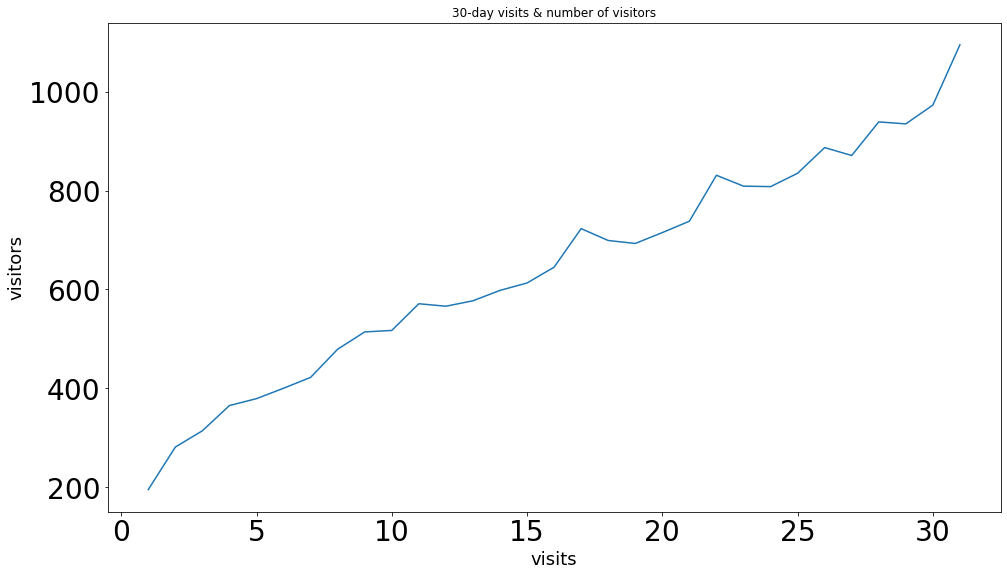

In [160]:
user_active_level = labels['counts_30_active'].value_counts().sort_index(ascending=False) 
plt.figure(figsize=(16,9)) 
user_active_level.plot(title='30-day visits & number of visitors',fontsize=28)
plt.xlabel('visits',fontsize=18) 
plt.ylabel('visitors',fontsize=18)

In [162]:
labels['user_active_level'] = 'High' 
labels.loc[labels['counts_30_active'] <= 16, 'user_active_level'] = 'Low' 
labels.head() 

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0,5.0,4.0,Yes,Yes,Yes,High
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0,7.0,NaN,Yes,Yes,No,Low
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0,NaN,NaN,Yes,Yes,No purchase,High
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0,7.0,19.0,Yes,Yes,Yes,High
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0,2.0,7.0,Yes,Yes,Yes,High


## Buying active level 

Text(0, 0.5, 'buyers')

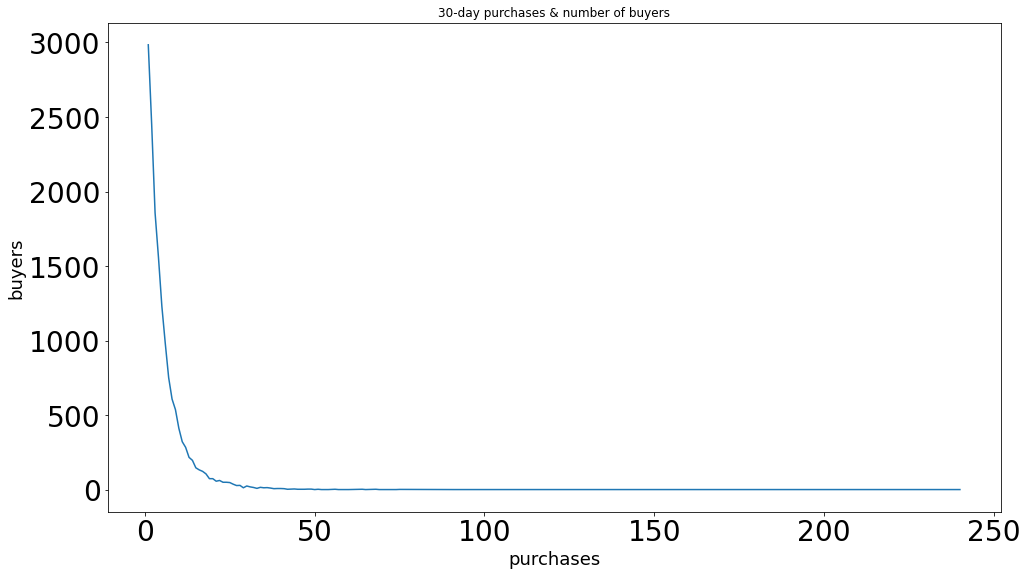

In [164]:
buy_active_level = labels['counts_30_buy'].value_counts().sort_index(ascending=False) 
plt.figure(figsize=(16,9)) 
buy_active_level.plot(title='30-day purchases & number of buyers',fontsize=28)
plt.xlabel('purchases',fontsize=18) 
plt.ylabel('buyers',fontsize=18) 


In [165]:
labels['buy_active_level'] = 'High' 
labels.loc[labels['counts_30_buy'] <= 16, 'buy_active_level'] = 'Low' 
labels.head() 

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_cart,counts_7_active,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,10.0,7.0,2.0,5.0,4.0,Yes,Yes,Yes,High,Low
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,7.0,5.0,2.0,7.0,NaN,Yes,Yes,No,Low,Low
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,17.0,5.0,1.0,NaN,NaN,Yes,Yes,No purchase,High,High
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,30.0,7.0,1.0,7.0,19.0,Yes,Yes,Yes,High,High
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,6.0,6.0,2.0,2.0,7.0,Yes,Yes,Yes,High,Low


## Purchasing single category or not 

In [173]:
buy_single = df[df['behavior_type']==4].groupby('user_id').item_category.nunique().reset_index()
buy_single.rename(columns={'item_category':'buy_single'},inplace=True)
buy_single

,user_id,buy_single
0,492,1
1,3726,4
2,37101,2
3,38745,1
4,45561,6
...,...,...
15630,142415742,4
15631,142424211,7
15632,142427508,2
15633,142432272,1


In [174]:
# add to label 
labels = pd.merge(labels,buy_single,how='left',on='user_id') 
labels['buy_single'].fillna(-1,inplace=True) 
labels['buy_single'] = labels['buy_single'].apply(lambda x: 'No' if x>1 else 'Yes')


## RFM 

**RFM model**
- Recency: How much time has elapsed since a customer’s last activity or transaction with the brand? 
- Frequency: How often has a customer transacted or interacted with the brand during a particular period of time? 
- Monetary: how much a customer has spent with the brand during a particular period of time 


Text(0.5, 0, 'Days')

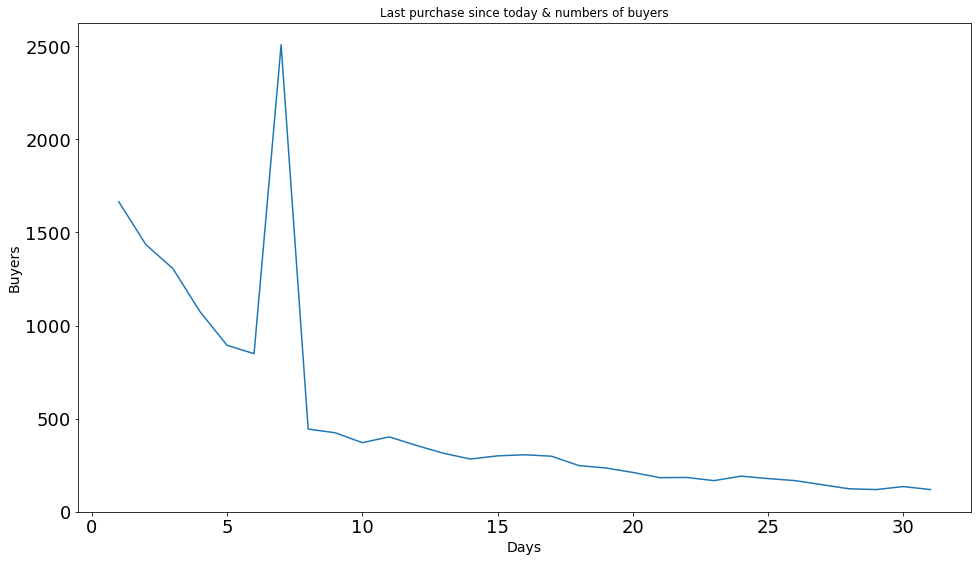

In [176]:
#recency 
last_buy_days = labels['days_buy'].value_counts().sort_index()
plt.figure(figsize=(16,9))
last_buy_days.plot(title='Last purchase since today & numbers of buyers',fontsize=18)
plt.ylabel('Buyers',fontsize=14)
plt.xlabel('Days',fontsize=14) 

In [177]:
# R(buy_days_level),F(buy_active_level) 
labels['buy_days_level'] = 'High' 
labels.loc[labels['days_buy'] >8, 'buy_days_level'] = 'Low' 
labels['rfm_value'] = labels['buy_active_level'].str.cat(labels['buy_days_level']) 

# connect active level with days_level 

In [178]:
def trans_value(x):
    if x == 'HighHigh':
        return 'Best Value' 
    if x == 'LowHigh':
        return 'Important Potential' 
    if x == 'HighLow':
        return 'Important Recall'
    else: 
        return 'Almost Lost'

In [179]:
labels['rfm'] = labels['rfm_value'].apply(trans_value)
labels.drop(['buy_days_level','rfm_value'],axis=1,inplace=True)
labels['rfm'].value_counts()  

Important Potential    9246
Almost Lost            5423
Best Value             5282
Important Recall         36
Name: rfm, dtype: int64

In [180]:
labels.head() 

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single_x,buy_single_y,buy_single_x,buy_single_y,buy_single,rfm
0,2903578,Evening,Afternoon,9559,"1863,7025","6513,11311,13404","1650,3944,13404",14.0,41.0,31,...,Yes,Yes,High,Low,No,11.0,No,11.0,No,Important Potential
1,19054708,Evening,Morning,5027,5027,3472,3942,1.0,7.0,7,...,Yes,No,Low,Low,Yes,1.0,Yes,1.0,Yes,Important Potential
2,125170892,Evening,NaN,5689,"5689,11279,12855",5689,NaN,NaN,115.0,24,...,Yes,No purchase,High,High,Yes,NaN,Yes,NaN,Yes,Best Value
3,24298813,Evening,Afternoon,13230,2334,8291,"6045,8586,9561",17.0,65.0,31,...,Yes,Yes,High,High,No,14.0,No,14.0,No,Best Value
4,129441411,Afternoon,Noon,1863,"2825,8877",1863,"738,7712,11756",12.0,36.0,29,...,Yes,Yes,High,Low,No,9.0,No,9.0,No,Important Potential
